#  3 Gaussian Mixture Model

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
from sklearn.cluster import KMeans

class GMM:
    def __init__(self, n_clusters, n_iter=100, tolerance=1e-3):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.tolerance = tolerance

    def init_parameters(self, X):
        n_samples, n_features = X.shape
        X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))

        #weights
        self.weights = np.ones(self.n_clusters) / self.n_clusters

        #KMeans to initialize means
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10).fit(X)
        self.means = kmeans.cluster_centers_

        #covariance 
        self.covar = np.array([np.cov(X.T) + np.eye(n_features) * 1e-4 for _ in range(self.n_clusters)])

    def e_part(self, X):
        X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))
        posterior_matrix = np.zeros((X.shape[0], self.n_clusters))
        
        for i in range(self.n_clusters):
            safe_cov = self.covar[i] + np.eye(self.covar[i].shape[0]) * 1e-6
             # PDF
            try:
                posterior_matrix[:,i] = self.weights[i] * multivariate_normal.pdf(
                    X, mean=self.means[i], cov=safe_cov, allow_singular=True
                )
            except Exception as e:
                print(f"Error in PDF for cluster {i}: {e}")
                posterior_matrix[:,i] = self.weights[i]
        
        #to avoid division by zero
        row_sums = posterior_matrix.sum(axis=1)
        row_sums[row_sums == 0] = 1e-10
        posterior_matrix /= row_sums[:, np.newaxis]
        
        return posterior_matrix

    def m_part(self, X, posterior_matrix):
        n_samples, n_features = X.shape
        
        for i in range(self.n_clusters):
            #posterior sum for the cluster
            post_sum = posterior_matrix[:,i].sum()
            if post_sum < 1e-10:
                continue
            
            # Updates
            self.weights[i] = post_sum / n_samples
            self.means[i] = np.sum(X * posterior_matrix[:,i][:, np.newaxis], axis=0) / post_sum

            diff = X - self.means[i]
            cov_matrix = np.sum(
                posterior_matrix[:,i][:, np.newaxis, np.newaxis] * 
                (diff[:, :, np.newaxis] * diff[:, np.newaxis, :]), 
                axis=0
            ) / post_sum
            
            #regularization to prevent singularity
            self.covar[i] = cov_matrix + np.eye(n_features) * 1e-6

    def train(self, X):
        X = np.atleast_2d(X)
        self.init_parameters(X)
        
        log_likelihood = -np.inf
        
        for _ in range(self.n_iter):
            #E-step
            posterior_matrix = self.e_part(X)
            
            #M-step
            self.m_part(X, posterior_matrix)
            
            #log-likelihood
            try:
                new_log_likelihood = np.sum(np.log(np.maximum(
                    np.sum([
                        self.weights[i] * multivariate_normal.pdf(
                            X, mean=self.means[i], cov=self.covar[i], allow_singular=True
                        ) for i in range(self.n_clusters)
                    ], axis=0), 
                    1e-10
                )))
            except Exception as e:
                print(f"Log-likelihood computation error: {e}")
                break
            
            #convergence
            if np.abs(new_log_likelihood - log_likelihood) < self.tolerance:
                break
            
            log_likelihood = new_log_likelihood

    def predict_prob(self, X):
        return self.e_part(X)

    def predict(self, X):
        return np.argmax(self.predict_prob(X), axis=1)

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

nii_image = nib.load("sald_031764_img.nii")
image_data = nii_image.get_fdata()

X = image_data.reshape(-1, 1)
X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))

#gmm
gmm = GMM(n_clusters=3,n_iter=100)
gmm.train(X)
labels = gmm.predict(X)

segmented_image = labels.reshape(image_data.shape)

#ground truth probability masks
gm_prob = nib.load("sald_031764_probmask_graymatter.nii").get_fdata()
wm_prob = nib.load("sald_031764_probmask_whitematter.nii").get_fdata()
csf_prob = nib.load("sald_031764_probmask_csf.nii").get_fdata()

#ground truth labels
ground_truth = np.argmax(np.stack([csf_prob, gm_prob, wm_prob], axis=-1), axis=-1)

#accuracy
accuracy = accuracy_score(ground_truth.flatten(), segmented_image.flatten())
print(f"Segmentation Accuracy: {accuracy * 100:.2f}%")

Segmentation Accuracy: 81.18%


In [9]:
correct_pixels = (ground_truth == segmented_image).sum()
total_pixels = ground_truth.size
pointwise_accuracy = (correct_pixels / total_pixels) * 100
print(f"Pointwise Accuracy: {pointwise_accuracy:.2f}%")

Pointwise Accuracy: 83.22%


In [19]:
means = gmm.means.flatten()  
covars = gmm.covar.flatten()  
weights = gmm.weights 
print("Cluster Means:", means)
print("Cluster Variances:", covars)
print("Cluster Weights:", weights)

Cluster Means: [ 0.         91.091796   35.89743156]
Cluster Variances: [1.00000000e-06 2.58613753e+02 5.50907489e+02]
Cluster Weights: [0.70599047 0.21823163 0.0757779 ]


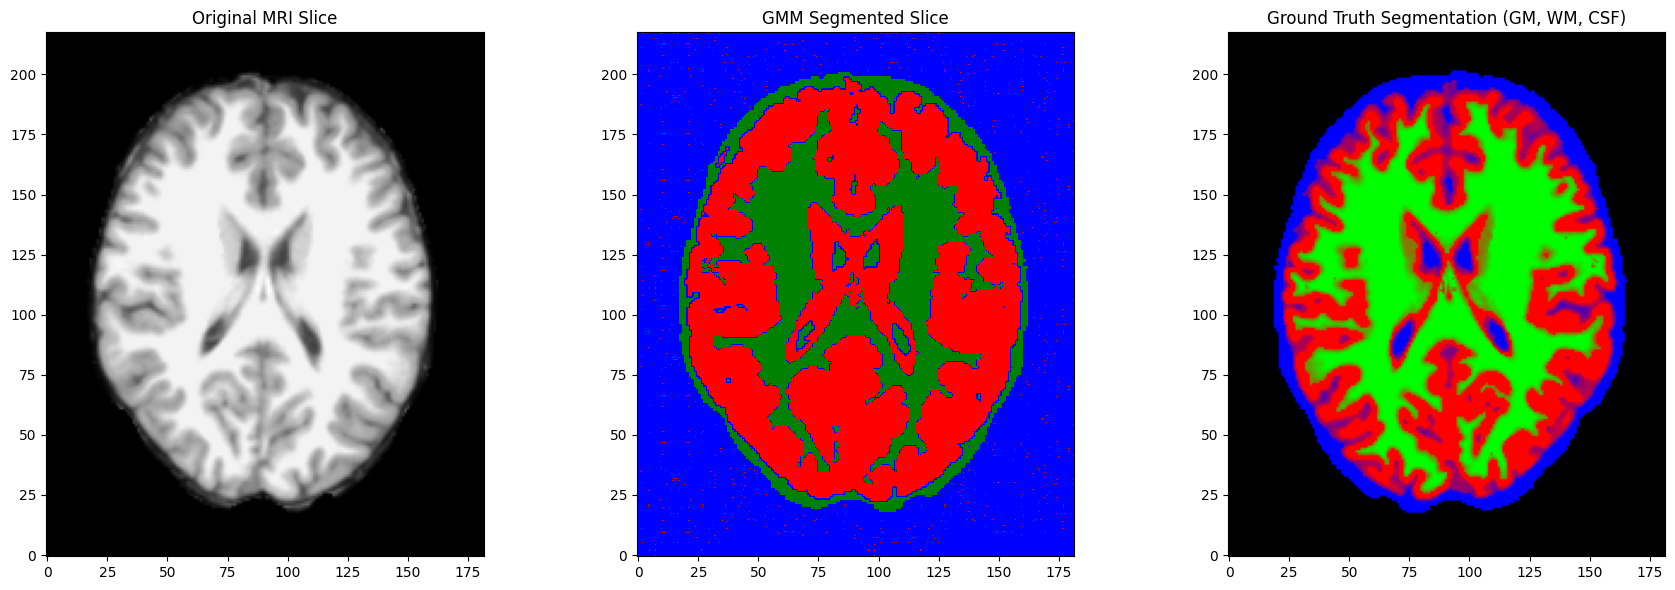

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from matplotlib.colors import ListedColormap

gm_prob = nib.load("sald_031764_probmask_graymatter.nii").get_fdata()
wm_prob = nib.load("sald_031764_probmask_whitematter.nii").get_fdata()
csf_prob = nib.load("sald_031764_probmask_csf.nii").get_fdata()

slice_idx = image_data.shape[2] // 2

original_slice = image_data[:, :, slice_idx]
segmented_slice = segmented_image[:, :, slice_idx]

gm_slice = gm_prob[:, :, slice_idx]
wm_slice = wm_prob[:, :, slice_idx]
csf_slice = csf_prob[:, :, slice_idx]

custom_cmap = ListedColormap([ "red","blue","green"]) 
ground_truth_rgb = np.zeros((*gm_slice.shape, 3))  

ground_truth_rgb[..., 0] = gm_slice  # Red for GM
ground_truth_rgb[..., 1] = wm_slice  # Green for WM
ground_truth_rgb[..., 2] = csf_slice  # Blue for CSF

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original MRI
axes[0].imshow(original_slice.T, cmap='gray', origin='lower')
axes[0].set_title("Original MRI Slice")

# GMM Segmented MRI
axes[1].imshow(segmented_slice.T, cmap=custom_cmap, origin="lower")
axes[1].set_title("GMM Segmented Slice")

# Ground Truth Segmentation (Overlay of GM, WM, CSF)
axes[2].imshow(np.rot90(ground_truth_rgb, k=-1), origin='lower')
axes[2].set_title("Ground Truth Segmentation (GM, WM, CSF)")

plt.tight_layout()
plt.show()

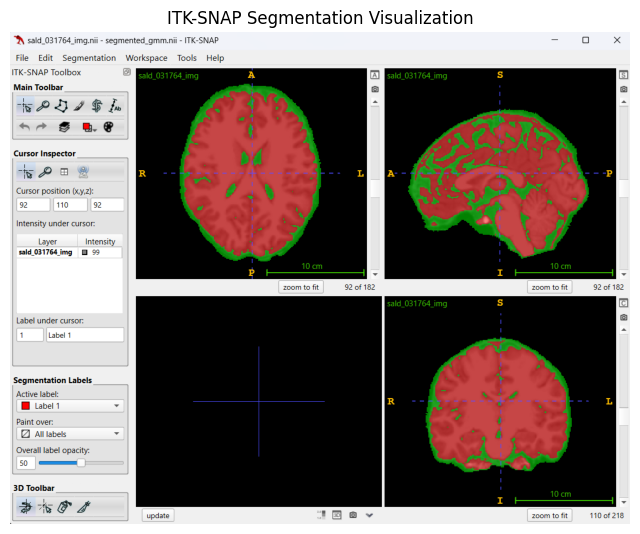

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#ITK-SNAP screenshot
img = mpimg.imread("itk-snap_segment.png")

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title("ITK-SNAP Segmentation Visualization")
plt.show()

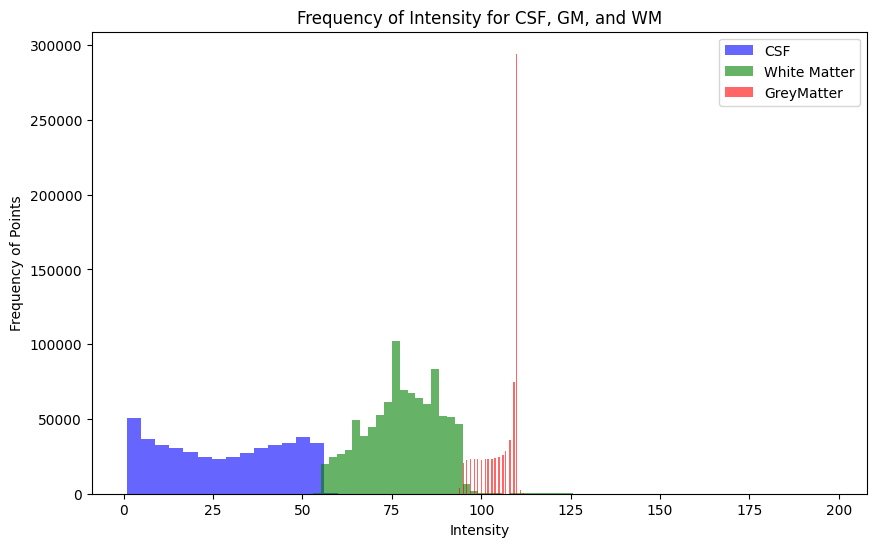

In [51]:
import numpy as np
import matplotlib.pyplot as plt

csf_intensities = image_data[csf_prob > 0.5].flatten()
gm_intensities = image_data[gm_prob > 0.5].flatten()
wm_intensities = image_data[wm_prob > 0.5].flatten()

plt.figure(figsize=(10, 6))
plt.hist(csf_intensities, bins=50, alpha=0.6, color='blue', label='CSF')
plt.hist(gm_intensities, bins=50, alpha=0.6, color='green', label='White Matter')
plt.hist(wm_intensities, bins=50, alpha=0.6, color='red', label='GreyMatter')

plt.xlabel('Intensity')
plt.ylabel('Frequency of Points')
plt.title('Frequency of Intensity for CSF, GM, and WM')
plt.legend()
plt.show()


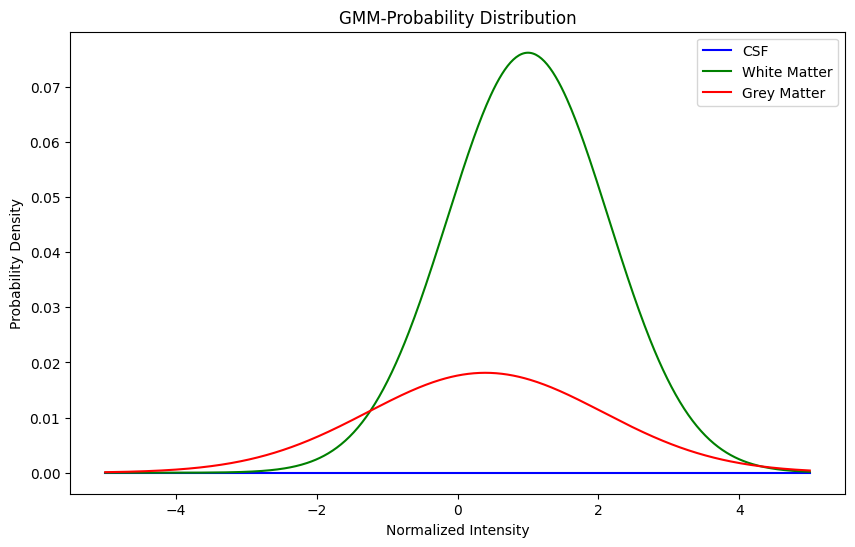

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(gmm.means).flatten()
normalized_vars = gmm.covar.flatten() / np.ptp(image_data) 
normalized_weights = gmm.weights

x = np.linspace(-5, 5, 500)  

plt.figure(figsize=(10, 6))

for mean, var, weight, color, label in zip(normalized_means, normalized_vars, normalized_weights, ['blue', 'green', 'red'], ['CSF', 'White Matter', 'Grey Matter']):
    pdf = weight * norm.pdf(x, mean, np.sqrt(var)) 
    plt.plot(x, pdf, color=color, label=label)

plt.xlabel('Normalized Intensity')
plt.ylabel('Probability Density')
plt.title('GMM-Probability Distribution')
plt.legend()
plt.show()

In [37]:
# segmented image as a NIfTI file
segmented_nii = nib.Nifti1Image(segmented_image.astype(np.uint8), affine=nii_image.affine)
nib.save(segmented_nii, "segmented_gmm.nii")

print("Segmented image saved as 'segmented_gmm.nii'")


Segmented image saved as 'segmented_gmm.nii'


### Highest misclassification
- GMM model is misclassifying the CSF, treating the entire background as a cluster instead of outlining the CSF region.
##### Reasons:
- Low Contrast with Background: CSF intensity often blends with the surrounding background or neighboring tissues like GM, making it difficult to distinguish.
- Thin & Irregular Boundaries: CSF is typically found around the brain edges, where segmentation becomes challenging due to irregular shapes and thin regions.
- Model Bias Toward Larger Structures: Since CSF regions are smaller and less distinct than GM/WM, the model may misclassify them as other tissues.
- Gaussian Mixture Model (GMM) Limitation: GMM assumes Gaussian distributions, but CSF intensity variations are often non-Gaussian due to noise and anatomical differences, making it harder to model accurately.